In [2]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.animation_artifact import AnimationArtifact

animation = 'joyful-jump:latest'
animation = AnimationArtifact.from_wandb_artifact_tag(animation)

frame = animation.get_frame_path(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.925808..4.0398946].


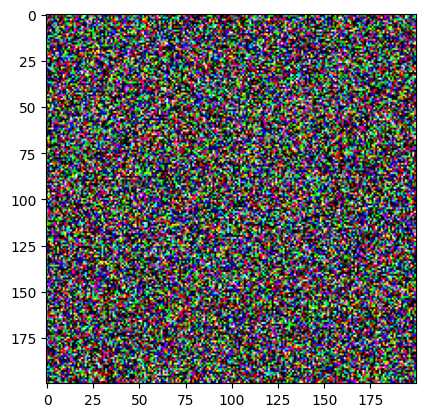

In [3]:
from pytorch3d.renderer import TexturesUV
import matplotlib.pyplot as plt
import torch

noise_texture_res = 200
uv_noise_texture = torch.randn(noise_texture_res, noise_texture_res, 3)

def generate_chekerboard(n):
    checkerboard = torch.zeros(n, n, 1)
    checkerboard[1::2, ::2, :] = 1
    checkerboard[::2, 1::2, :] = 1
    return checkerboard

# uv_noise_texture = generate_chekerboard(200)

# normalize
plt.imshow(uv_noise_texture)

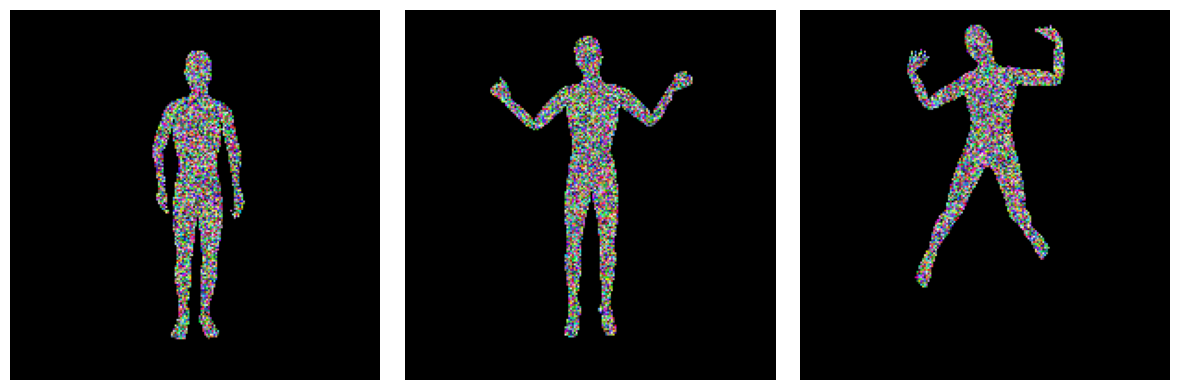

In [4]:
from einops import rearrange
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import make_feature_renderer
from text3d2video.util import front_camera
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
import torchvision.transforms.functional as TF

frame_nums = [10, 20, 30]

renders = []

for num in frame_nums:

    frame = animation.get_frame_path(num)

    device = 'cuda'
    verts, faces, aux = load_obj(frame)

    # uv_noise_texture = torch.ones(100, 100, 1) * 0.1

    tex = TexturesUV(
        verts_uvs=[aux.verts_uvs.to(device)],
        faces_uvs=[faces.textures_idx.to(device)],
        maps=[uv_noise_texture.to(device)],
    )

    mesh = Meshes(
        verts=[verts.to(device)],
        faces=[faces.verts_idx.to(device)],
        textures=tex
    )

    camera = front_camera()
    renderer = make_feature_renderer(camera, 200)

    render = renderer(mesh)
    render = rearrange(render, '1 h w c -> c h w')
    render = TF.to_pil_image(render.detach().cpu())
    renders.append(render) 

display_ims(renders, scale=4)

In [9]:
verts_uvs, faces_uvs = animation.texture_data()